# Customer Churn Prediction

### import dependencies

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.feature_selection import mutual_info_classif
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

from tensorflow import keras
import tensorflow as tf
from keras import metrics

from sklearn.metrics import classification_report

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier

from sklearn.metrics import accuracy_score, precision_score, f1_score
from sklearn.model_selection import cross_val_score
from keras.callbacks import ModelCheckpoint

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Load data

In [3]:
data = pd.read_csv(r'/content/drive/MyDrive/Documents/Machine Learning/Telco-Customer-Churn.csv')
data.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


# Exploratory Data Analysis and Data Cleaning

In [ ]:
data.columns

Index(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'tenure', 'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn'],
      dtype='object')

In [ ]:
# check for null values
data.isnull().sum()

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

In [ ]:
# checking number of unique values per column
for col in data:
  print(f'{col} : {data[col].nunique()}')

customerID : 7043
gender : 2
SeniorCitizen : 2
Partner : 2
Dependents : 2
tenure : 73
PhoneService : 2
MultipleLines : 3
InternetService : 3
OnlineSecurity : 3
OnlineBackup : 3
DeviceProtection : 3
TechSupport : 3
StreamingTV : 3
StreamingMovies : 3
Contract : 3
PaperlessBilling : 2
PaymentMethod : 4
MonthlyCharges : 1585
TotalCharges : 6531
Churn : 2


In [4]:
# due to no predictive power, customer ID column has to be removed
df = data.drop(columns = 'customerID')

In [ ]:
# checking data types
df.dtypes

gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object

In [5]:
# changing object data type to category
obj_cols = df.dtypes[df.dtypes == 'object'].index

# df[obj_cols] = df[obj_cols].astype('category')

In [6]:
# check column data types
df.dtypes

,0
gender,object
SeniorCitizen,int64
Partner,object
Dependents,object
tenure,int64
PhoneService,object
MultipleLines,object
InternetService,object
OnlineSecurity,object
OnlineBackup,object


In [7]:
# check summary statistics for Total Charges column
df.loc[df['TotalCharges'] != ' ']['TotalCharges'].astype('object').astype('float').describe()

,TotalCharges
count,7032.000000
mean,2283.300441
std,2266.771362
min,18.800000
25%,401.450000
50%,1397.475000
75%,3794.737500
max,8684.800000


The Total Charges column has the data type category and it has to be changed to float. It appears that there are some blank values that have to be properly dealt with.


In [8]:
no_chrg_df = df.loc[df['TotalCharges'] == ' ']
print(f"{len(no_chrg_df)} out of {len(df)} records had a blank Total Charge")

11 out of 7043 records had a blank Total Charge


Because there is few records with blanks in Total Charge, they will be dropped/excluded.

In [9]:
# exclude the 11 rows and convert to float data type
df1 = df.loc[df['TotalCharges'] != ' ']

df1['TotalCharges'] = df1['TotalCharges'].astype('object').astype('float')

<ipython-input-9-3feec19c597c>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['TotalCharges'] = df1['TotalCharges'].astype('object').astype('float')


# Data Visualizations

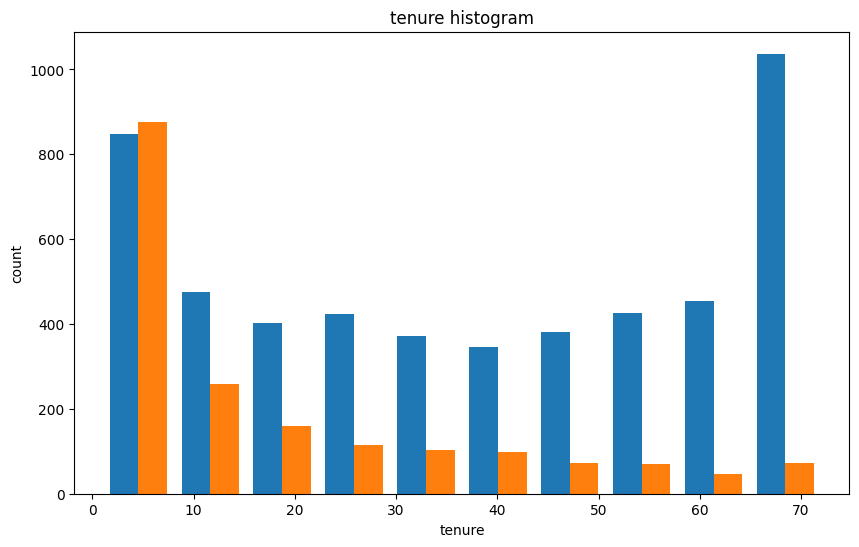

In [10]:
no_churn = df1[df1['Churn'] == 'No'].tenure
yes_churn = df1[df1['Churn'] == 'Yes'].tenure

plt.figure(figsize = (10, 6))
plt.hist([no_churn, yes_churn])
plt.title('tenure histogram')
plt.xlabel('tenure')
plt.ylabel('count')
plt.show()

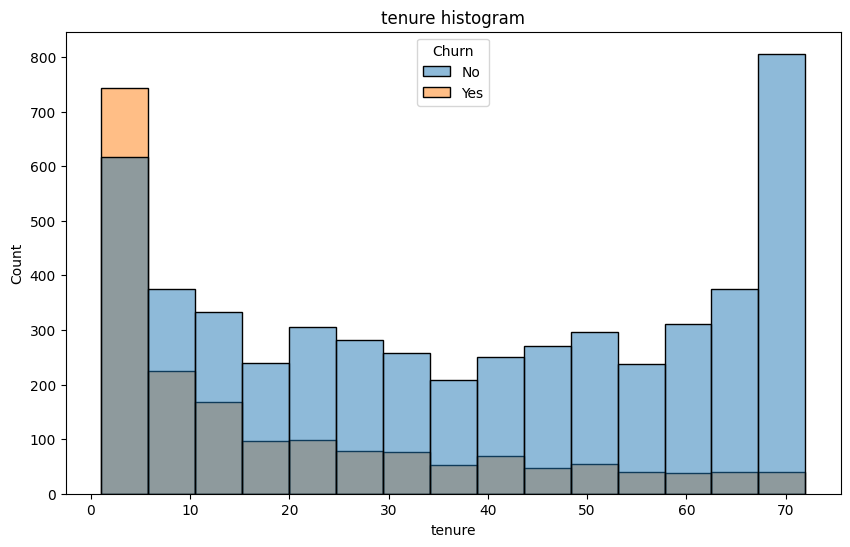

<Figure size 1000x700 with 0 Axes>

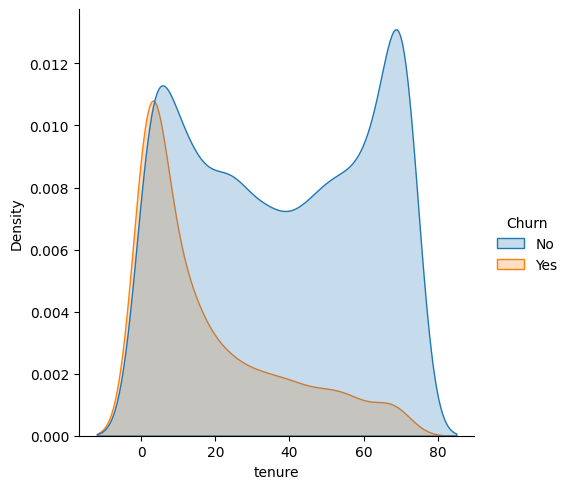

In [ ]:
plt.figure(figsize = (10, 6))
plt.title('tenure histogram')
sns.histplot(data = df1, x = 'tenure', hue= 'Churn')
plt.show()

# distribution plot
plt.figure(figsize = (10, 7))
sns.displot(data = df1, x = 'tenure', hue = 'Churn', kind = 'kde', fill = True)
plt.show()

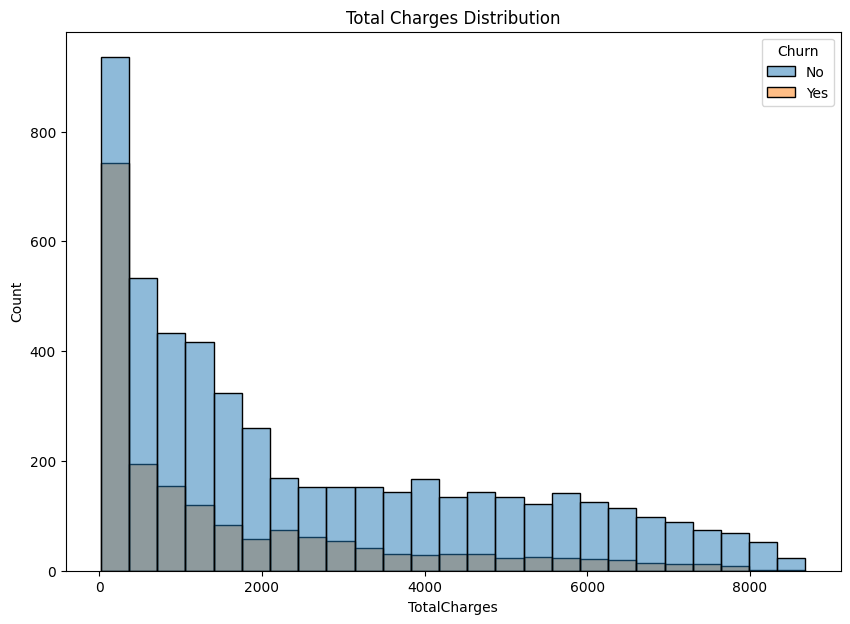

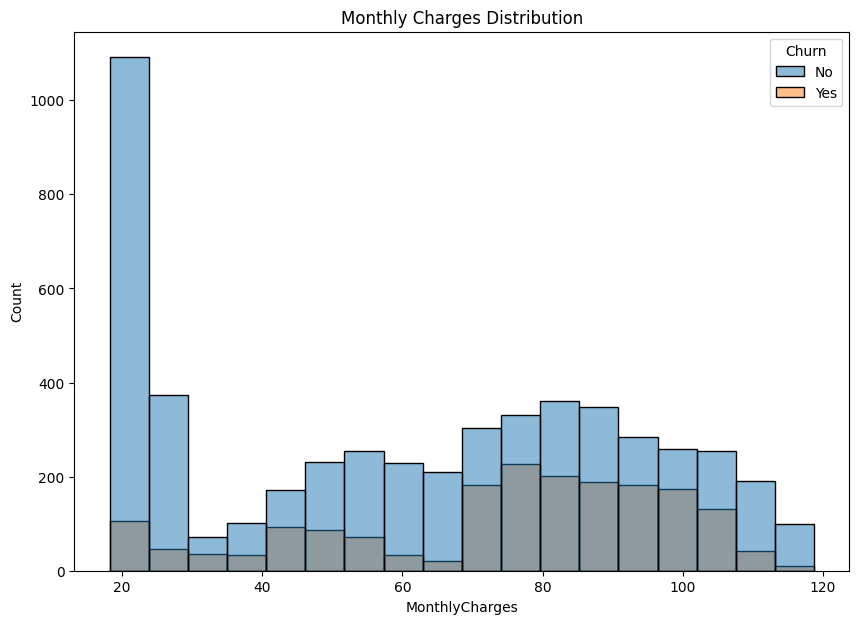

In [ ]:
# Total Charges distribution plot
plt.figure(figsize = (10, 7))
sns.histplot(data = df1, x = 'TotalCharges', hue = 'Churn')
plt.title('Total Charges Distribution')
plt.show()

# Total Charges distribution plot
plt.figure(figsize = (10, 7))
sns.histplot(data = df1, x = 'MonthlyCharges', hue = 'Churn')
plt.title('Monthly Charges Distribution')
plt.show()



Having seen that the Total Charges and Monthly Charges features are skewed, the scaling method we will use is Robust Scaler. It uses the median and interquartile range to scale and it is useful for skewed data and outliers.

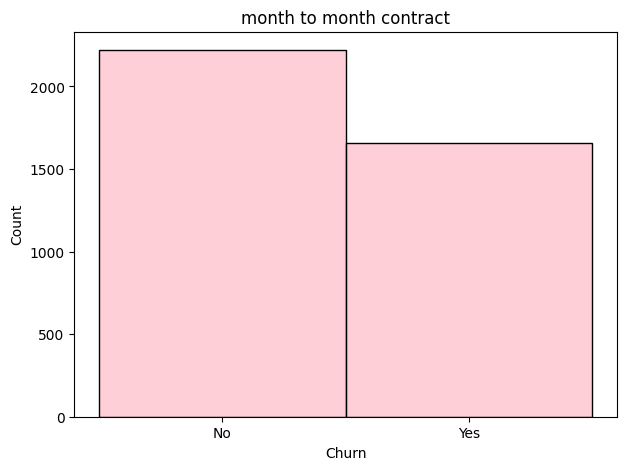

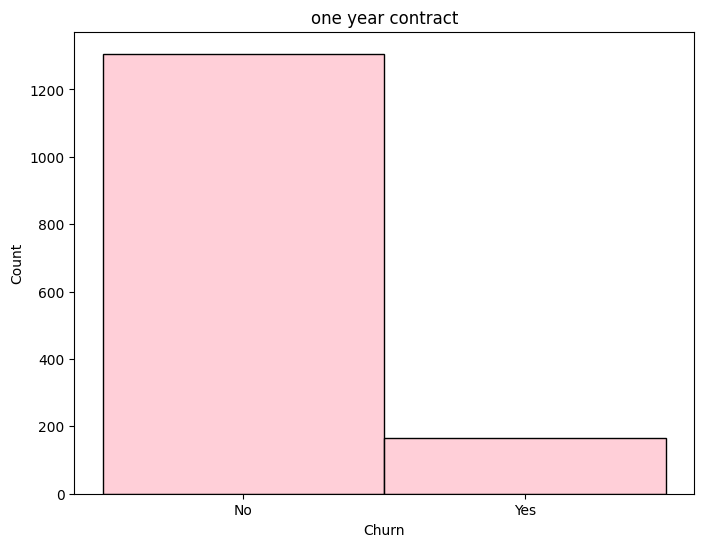

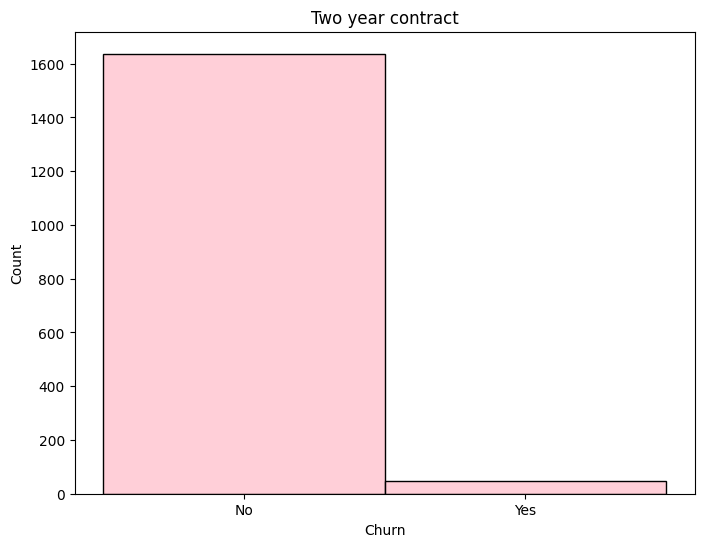

In [14]:
# Let's check churn by Contract

monthly_contr = df1[df1.Contract == 'Month-to-month']
oneyr_contr = df1[df1.Contract == 'One year']
twoyr_contr = df1[df1.Contract == 'Two year']

plt.figure(figsize = (7, 5))
plt.title('month to month contract')
sns.histplot(data = monthly_contr, x = 'Churn', color = 'pink')
plt.show()

plt.figure(figsize = (8, 6))
plt.title('one year contract')
sns.histplot(data = oneyr_contr, x = 'Churn', color = 'pink')
plt.show()

plt.figure(figsize = (8, 6))
plt.title('Two year contract')
sns.histplot(data = twoyr_contr, x = 'Churn', color = 'pink')
plt.show()

One thing we must check is whether our dataset is balanced. Imbalanced datasets can lead to biased model performance and affect the accuracy of our predictions.

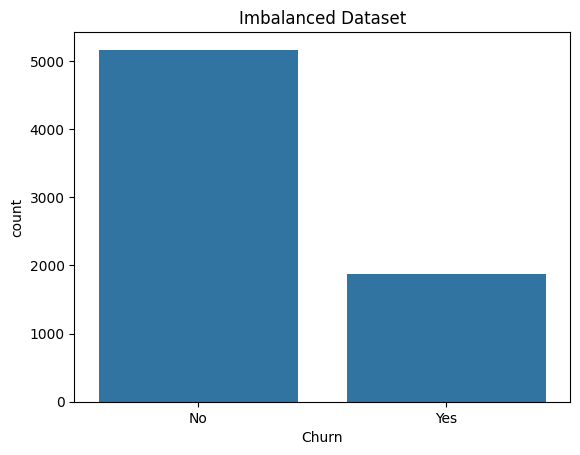

In [ ]:
sns.countplot(data = df1, x = 'Churn')
plt.title('Imbalanced Dataset')
plt.show()

# Data Pre-Processing

The first step under data pre-processing will be solving the imbalance in our target variable.

In [43]:
churn_yes = df1[df1['Churn'] == 'Yes']
churn_no = df1[df1['Churn'] == 'No']

#fix imbalance by oversampling
yes_churn_resampled = churn_yes.sample(n = len(churn_no), replace = True, random_state = 42)

resampled_df = pd.concat([churn_no, yes_churn_resampled])

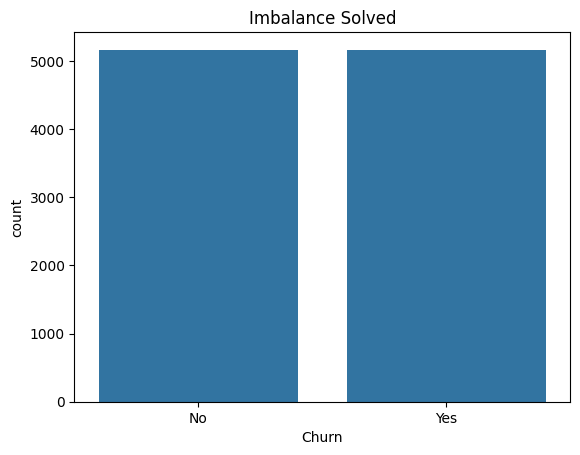

In [ ]:
sns.countplot(data = resampled_df, x = 'Churn')
plt.title('Imbalance Solved')
plt.show()

In [44]:
# check columns with category data type
cat_cols = resampled_df.dtypes[resampled_df.dtypes == 'object'].index
cat_cols

Index(['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines',
       'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
       'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract',
       'PaperlessBilling', 'PaymentMethod', 'Churn'],
      dtype='object')

In [45]:
# check unique values in each of the object data type columns

for col in resampled_df.dtypes[resampled_df.dtypes == 'object'].index:
  print(f'{col}   {resampled_df[col].unique()}\n')

gender   ['Female' 'Male']

Partner   ['Yes' 'No']

Dependents   ['No' 'Yes']

PhoneService   ['No' 'Yes']

MultipleLines   ['No phone service' 'No' 'Yes']

InternetService   ['DSL' 'Fiber optic' 'No']

OnlineSecurity   ['No' 'Yes' 'No internet service']

OnlineBackup   ['Yes' 'No' 'No internet service']

DeviceProtection   ['No' 'Yes' 'No internet service']

TechSupport   ['No' 'Yes' 'No internet service']

StreamingTV   ['No' 'Yes' 'No internet service']

StreamingMovies   ['No' 'No internet service' 'Yes']

Contract   ['Month-to-month' 'One year' 'Two year']

PaperlessBilling   ['Yes' 'No']

PaymentMethod   ['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit card (automatic)']

Churn   ['No' 'Yes']



### Categorical features encoding

In [46]:
yes_no_cols = []
for col in resampled_df.columns:
  if (pd.Series(resampled_df[col].unique()).isin(['No', 'Yes']).any()) and (len(resampled_df[col].unique()) == 2):
    yes_no_cols.append(col)

non_dummies_feats = yes_no_cols + ['Contract']

In [73]:
dummy_cols = ['gender', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'PaymentMethod']

In [68]:
resampled_df.dtypes[resampled_df.dtypes != object].index

Index(['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges'], dtype='object')

In [74]:
# Encoding our categorical columns


pd.set_option('future.no_silent_downcasting', True)


df2 = pd.get_dummies(data = resampled_df, columns = dummy_cols, drop_first =True)
df2[non_dummies_feats] = df2[non_dummies_feats].replace({ 'Yes': 1,
                                                          'No': 0,
                                                          'Month-to-month': 0,
                                                          'One year': 1,
                                                          'Two year': 2})

df2.replace({False: 0, True: 1}, inplace = True)
df2.head()

,SeniorCitizen,Partner,Dependents,tenure,PhoneService,Contract,PaperlessBilling,MonthlyCharges,TotalCharges,Churn,...,DeviceProtection_Yes,TechSupport_No internet service,TechSupport_Yes,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,0,1,0,1,0,0,1,29.85,29.85,0,...,0,0,0,0,0,0,0,0,1,0
1,0,0,0,34,1,1,0,56.95,1889.50,0,...,1,0,0,0,0,0,0,0,0,1
3,0,0,0,45,0,1,0,42.30,1840.75,0,...,1,0,1,0,0,0,0,0,0,0
6,0,0,1,22,1,0,1,89.10,1949.40,0,...,0,0,0,0,1,0,0,1,0,0
7,0,0,0,10,0,0,0,29.75,301.90,0,...,0,0,0,0,0,0,0,0,0,1


###Feature Importance

To prevent including features with little predictive power, which could lead to overfitting and unnecessary complexity, we have to check feature importance and perform feature selection to identify the most informative variables to our target variable (Churn).

In [ ]:
numrs_cols = resampled_df.dtypes[resampled_df.dtypes != 'category'].index
cats_cols = resampled_df.dtypes[resampled_df.dtypes == 'category'].index

# Calculate mutual information for numerical features
numrs_mut_inf_scores = mutual_info_classif(resampled_df[numrs_cols], resampled_df['Churn'])


# Calculate mutual information for categorical features
cat_mut_inf_scores_ = mutual_info_classif(resampled_df[cats_cols], resampled_df['Churn'], discrete_features=True)


# Create a DataFrame with feature names and their mutual information scores
feature_importances = pd.DataFrame({'feature': cats_cols.tolist() + numrs_cols.tolist(),
                                   'mutual_information': list(cat_mut_inf_scores_) + list(numrs_mut_inf_scores)})


In [ ]:
feature_importances = feature_importances.sort_values('mutual_information', ascending = False)[1:]
feature_importances

,feature,mutual_information
19,TotalCharges,0.270409
18,MonthlyCharges,0.160555
12,Contract,0.134376
17,tenure,0.105970
9,TechSupport,0.082872
6,OnlineSecurity,0.082408
5,InternetService,0.071721
7,OnlineBackup,0.061113
8,DeviceProtection,0.059549
14,PaymentMethod,0.056938


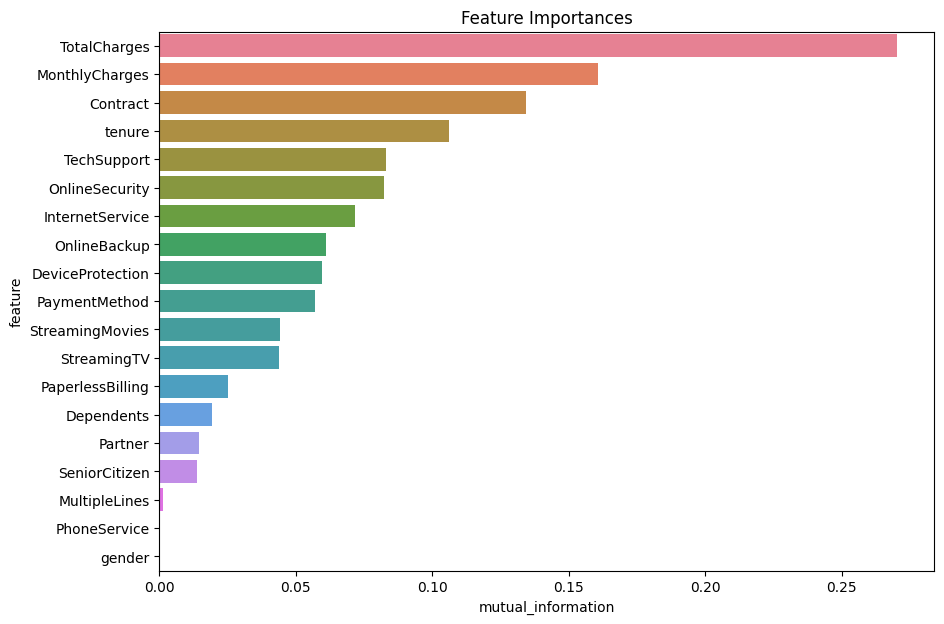

In [ ]:
plt.figure(figsize = (10, 7))
sns.barplot(data = feature_importances, x = 'mutual_information', y = 'feature', hue = 'feature', legend = False)
plt.title('Feature Importances')
plt.show()

###Feature Selection

In [ ]:
# removing the bottom 7 features with lesser scores
new_features = feature_importances[:-7]
new_features

,feature,mutual_information
19,TotalCharges,0.270409
18,MonthlyCharges,0.160555
12,Contract,0.134376
17,tenure,0.105970
9,TechSupport,0.082872
6,OnlineSecurity,0.082408
5,InternetService,0.071721
7,OnlineBackup,0.061113
8,DeviceProtection,0.059549
14,PaymentMethod,0.056938


In [ ]:
# select only the new columns from the dataframe
new_cols = new_features['feature'].tolist()

df2 = resampled_df[new_cols + ['Churn']]

In [ ]:
# split the target variable and the input variables
X = df4.drop(columns = 'Churn')
y = df4['Churn']

## Feature Scaling

In [ ]:
# scaling data
scaler = RobustScaler()
X[['MonthlyCharges', 'TotalCharges', 'tenure']] = scaler.fit_transform(X[['MonthlyCharges', 'TotalCharges', 'tenure']])

X[['MonthlyCharges', 'TotalCharges', 'tenure']].tail()            # The features are properly scaled

,MonthlyCharges,TotalCharges,tenure
2323,0.534216,0.602665,0.181818
4499,0.086093,-0.075924,-0.204545
3384,-0.014349,-0.271660,-0.386364
1327,0.554084,1.617857,0.863636
5591,0.310155,-0.256505,-0.386364


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.15, random_state= 4)

In [ ]:
X_train.shape

(8777, 21)

# **Model Building**

In [ ]:
# Constructing Artificial Neural Network model architecture

model = keras.Sequential([
    keras.layers.Dense(600, input_shape = (21,), activation = 'relu'),
    keras.layers.Dense(320, activation = 'relu'),
    keras.layers.Dense(190, activation=keras.layers.LeakyReLU(alpha=0.16)),
    keras.layers.Dense(190, activation = 'relu'),
    keras.layers.Dense(70, activation = 'relu'),
    keras.layers.Dense(1, activation = 'sigmoid')
])

# compile model
model.compile(optimizer = 'SGD', loss = 'binary_crossentropy', metrics= ['accuracy', metrics.Precision()])

Use Model Checkpoint to save best model

In [ ]:
#  Train model
checkpoint = ModelCheckpoint('/content/drive/MyDrive/ML models/best_churn_ann_model.h5', monitor = 'val_loss', save_best_only = True, mode  ='min')

model.fit(X_train, y_train, epochs = 100, validation_split = 0.15, shuffle =True,  callbacks=[checkpoint])

Epoch 1/100
232/234 [============================>.] - ETA: 0s - loss: 0.6469 - accuracy: 0.7287 - precision_1: 0.6923

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


234/234 [==============================] - 5s 11ms/step - loss: 0.6466 - accuracy: 0.7290 - precision_1: 0.6928 - val_loss: 0.5881 - val_accuracy: 0.7434 - val_precision_1: 0.7378
Epoch 2/100
234/234 [==============================] - 2s 8ms/step - loss: 0.5302 - accuracy: 0.7627 - precision_1: 0.7416 - val_loss: 0.5161 - val_accuracy: 0.7418 - val_precision_1: 0.7061
Epoch 3/100
234/234 [==============================] - 3s 12ms/step - loss: 0.4940 - accuracy: 0.7617 - precision_1: 0.7405 - val_loss: 0.5121 - val_accuracy: 0.7464 - val_precision_1: 0.6965
Epoch 4/100
234/234 [==============================] - 2s 10ms/step - loss: 0.4877 - accuracy: 0.7623 - precision_1: 0.7437 - val_loss: 0.5034 - val_accuracy: 0.7441 - val_precision_1: 0.7397
Epoch 5/100
234/234 [==============================] - 2s 6ms/step - loss: 0.4840 - accuracy: 0.7617 - precision_1: 0.7474 - val_loss: 0.5053 - val_accuracy: 0.7441 - val_precision_1: 0.7353
Epoch 6/100
234/234 [==============================] -

# Make Predictions

In [ ]:
best_model = keras.models.load_model('/content/drive/MyDrive/ML models/best_churn_ann_model.h5')

ann_predictions = model.predict(X_test)

# converting values to Binary digits
def convert_to_binary(predictions, threshold= 0.5):
    binary_predictions = np.where(predictions > threshold, 1, 0)
    return binary_predictions

ann_predictions = convert_to_binary(ann_predictions)
ann_predictions[:6]

49/49 [==============================] - 0s 8ms/step


array([[0],
       [0],
       [0],
       [1],
       [0],
       [1]])

In [ ]:
print(classification_report(y_test, ann_predictions))

              precision    recall  f1-score   support

           0       0.61      0.91      0.73       767
           1       0.83      0.43      0.56       782

    accuracy                           0.67      1549
   macro avg       0.72      0.67      0.65      1549
weighted avg       0.72      0.67      0.65      1549



# Trying other models

I will compare performance of different models to Neural Networks

In [ ]:
log_reg = LogisticRegression(random_state = 43)
rfc = RandomForestClassifier(random_state = 43)
gbc = GradientBoostingClassifier(random_state = 43)
svm = SVC(kernel = 'rbf', random_state = 43)
xgb = XGBClassifier(random_state = 43)


#                   XGBoost Classifier
xgb.fit(X_train, y_train)
xgb_pred = xgb.predict(X_test)

#            evaluation

print(f"XGBoost Classifier \n{classification_report(y_test, xgb_pred)}")


#                   LOGISTIC REGRESSION
log_reg.fit(X_train, y_train)
log_predictions = log_reg.predict(X_test)

#            evaluation

print(f"Logistic Regression\n {classification_report(y_test, log_predictions)}")



#                   RANDOM FOREST CLASSIFIER
rfc.fit(X_train, y_train)
rfc_predictions = rfc.predict(X_test)

#            evaluation
print(f"Random Forest Classifier\n {classification_report(y_test, rfc_predictions)}")


#                   GRADIENT BOOSTING
gbc.fit(X_train, y_train)
gbc_predictions = gbc.predict(X_test)

#            evaluation

print(f"Gradient Boosting \n{classification_report(y_test, gbc_predictions)}")



#                   SVM
svm.fit(X_train, y_train)
svm_predictions = svm.predict(X_test)

#            evaluation
print(f"Support Vector Machines \n{classification_report(y_test, svm_predictions)})")

XGBoost Classifier 
              precision    recall  f1-score   support

           0       0.91      0.76      0.83       767
           1       0.80      0.93      0.86       782

    accuracy                           0.84      1549
   macro avg       0.85      0.84      0.84      1549
weighted avg       0.85      0.84      0.84      1549

Logistic Regression
               precision    recall  f1-score   support

           0       0.78      0.70      0.74       767
           1       0.73      0.80      0.76       782

    accuracy                           0.75      1549
   macro avg       0.75      0.75      0.75      1549
weighted avg       0.75      0.75      0.75      1549

Random Forest Classifier
               precision    recall  f1-score   support

           0       0.96      0.83      0.89       767
           1       0.85      0.97      0.91       782

    accuracy                           0.90      1549
   macro avg       0.91      0.90      0.90      1549
weighte

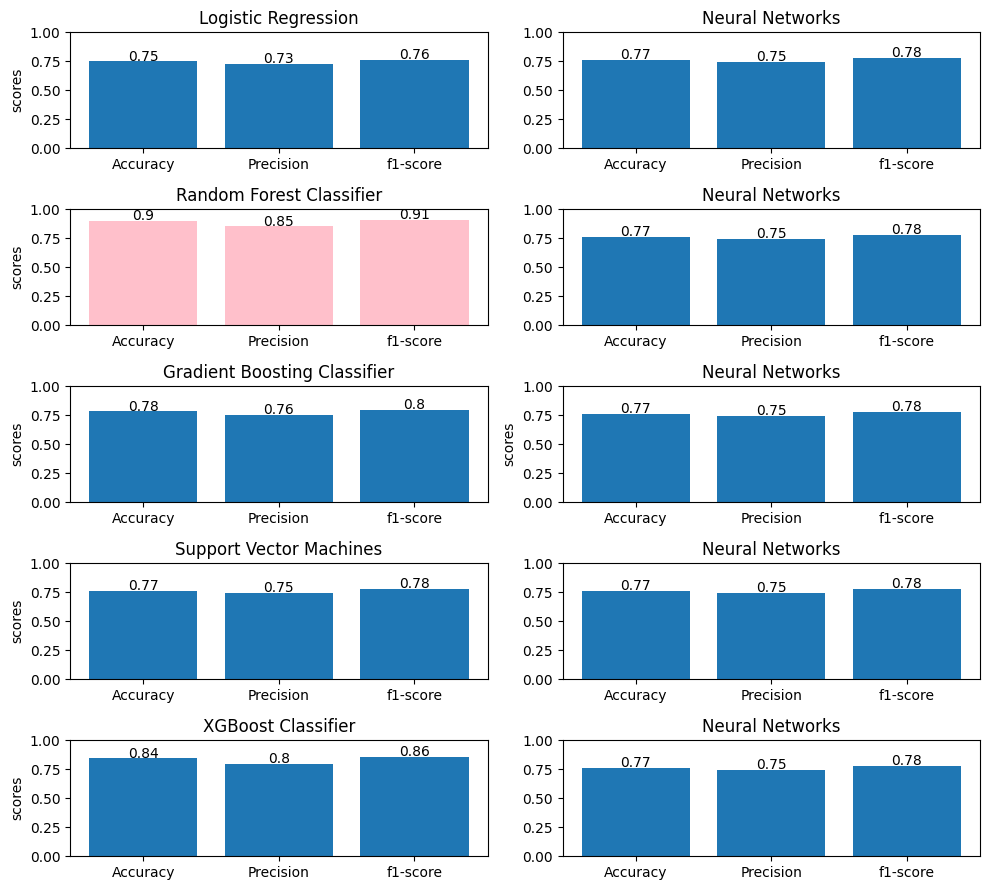

In [ ]:
# scores for XGBoost Classifier
xgb_acc_score = accuracy_score(y_test, xgb_pred)
xgb_prec_score = precision_score(y_test, xgb_pred)
xgb_f1_score = f1_score(y_test, xgb_pred)


# scores for logistic regression
log_acc_score = accuracy_score(y_test, log_predictions)
log_prec_score = precision_score(y_test, log_predictions)
log_f1_score = f1_score(y_test, log_predictions)

# scores for random forest classifier
rfc_acc_score = accuracy_score(y_test, rfc_predictions)
rfc_prec_score = precision_score(y_test, rfc_predictions)
rfc_f1_score = f1_score(y_test, rfc_predictions)

# scores for gradient boosting classifier
gbc_acc_score = accuracy_score(y_test, gbc_predictions)
gbc_prec_score = precision_score(y_test, gbc_predictions)
gbc_f1_score = f1_score(y_test, gbc_predictions)

# scores for support vector machines
svm_acc_score = accuracy_score(y_test, svm_predictions)
svm_prec_score = precision_score(y_test, svm_predictions)
svm_f1_score = f1_score(y_test, svm_predictions)

# scores for artificial neural network
dl_acc_score = accuracy_score(y_test, svm_predictions)
dl_prec_score = precision_score(y_test, svm_predictions)
dl_f1_score = f1_score(y_test, svm_predictions)



#  prepare for plots

xgb_metrics = ['Accuracy', 'Precision', 'f1-score']
xgb_scores = [xgb_acc_score, xgb_prec_score, xgb_f1_score]


logistic_regression_metrics = ['Accuracy', 'Precision', 'f1-score']
logistic_regression_scores = [log_acc_score, log_prec_score, log_f1_score]

rfc_metrics = ['Accuracy', 'Precision', 'f1-score']
rfc_scores = [rfc_acc_score, rfc_prec_score, rfc_f1_score]

gbc_metrics = ['Accuracy', 'Precision', 'f1-score']
gbc_scores = [gbc_acc_score, gbc_prec_score, gbc_f1_score]

svm_metrics = ['Accuracy', 'Precision', 'f1-score']
svm_scores = [svm_acc_score, svm_prec_score, svm_f1_score]

dl_metrics = ['Accuracy', 'Precision', 'f1-score']
dl_scores = [dl_acc_score, dl_prec_score, dl_f1_score]


# plotting the scores vs Neural Network
def plot_texts(scores):
    for index, score in enumerate(scores):
        plt.text(x=index, y= score+0.004, s=str(round(score,1)), ha='center')


fig, ax = plt.subplots(5, 2, figsize = (10, 9))

ax[0, 0].bar(logistic_regression_metrics, logistic_regression_scores)
ax[0, 0].set_ylim(0, 1)
ax[0, 0].set_title('Logistic Regression')
ax[0, 0].set_ylabel('scores')
ax[0, 1].bar(dl_metrics, dl_scores)
ax[0, 1].set_ylim(0, 1)
ax[0, 1].set_title('Neural Networks')
for index, score in enumerate(logistic_regression_scores):
    ax[0, 0].text(x=index, y= score+0.006, s=str(round(score,2)), ha='center')
for index, score in enumerate(dl_scores):
    ax[0, 1].text(x=index, y= score+0.006, s=str(round(score,2)), ha='center')


ax[1, 0].bar(rfc_metrics, rfc_scores, color = 'Pink')
ax[1, 0].set_ylim(0, 1)
ax[1, 0].set_title('Random Forest Classifier')
ax[1, 0].set_ylabel('scores')
ax[1, 1].bar(dl_metrics, dl_scores)
ax[1, 1].set_ylim(0, 1)
ax[1, 1].set_title('Neural Networks')
for index, score in enumerate(rfc_scores):
    ax[1, 0].text(x=index, y= score+0.006, s=str(round(score,2)), ha='center')
for index, score in enumerate(dl_scores):
    ax[1, 1].text(x=index, y= score+0.006, s=str(round(score,2)), ha='center')


ax[2, 0].bar(gbc_metrics, gbc_scores)
ax[2, 0].set_ylim(0, 1)
ax[2, 0].set_ylabel('scores')
ax[2, 0].set_title('Gradient Boosting Classifier')
ax[2, 1].bar(dl_metrics, dl_scores)
ax[2, 1].set_ylim(0, 1)
ax[2, 1].set_ylabel('scores')
ax[2, 1].set_title('Neural Networks')
for index, score in enumerate(gbc_scores):
    ax[2, 0].text(x=index, y= score+0.006, s=str(round(score,2)), ha='center')
for index, score in enumerate(dl_scores):
    ax[2, 1].text(x=index, y= score+0.006, s=str(round(score,2)), ha='center')


ax[3, 0].bar(svm_metrics, svm_scores)
ax[3, 0].set_ylabel('scores')
ax[3, 0].set_ylim(0, 1)
ax[3, 0].set_title('Support Vector Machines')
ax[3, 1].bar(dl_metrics, dl_scores)
ax[3, 1].set_ylim(0, 1)
ax[3, 1].set_title('Neural Networks')
for index, score in enumerate(svm_scores):
    ax[3, 0].text(x=index, y= score+0.006, s=str(round(score,2)), ha='center')
for index, score in enumerate(dl_scores):
    ax[3, 1].text(x=index, y= score+0.006, s=str(round(score,2)), ha='center')


ax[4, 0].bar(xgb_metrics, xgb_scores)
ax[4, 0].set_ylabel('scores')
ax[4, 0].set_ylim(0, 1)
ax[4, 0].set_title('XGBoost Classifier')
ax[4, 1].bar(dl_metrics, dl_scores)
ax[4, 1].set_ylim(0, 1)
ax[4, 1].set_title('Neural Networks')
for index, score in enumerate(xgb_scores):
    ax[4, 0].text(x=index, y= score+0.006, s=str(round(score,2)), ha='center')
for index, score in enumerate(dl_scores):
    ax[4, 1].text(x=index, y= score+0.006, s=str(round(score,2)), ha='center')

plt.tight_layout()
plt.show()


For this problem, Logistic Regression and the Gradient Boosting Classifier seem to slightly outperform the others.

# Hyperparameter Tuning - Random Forest Regressor

In [ ]:
!pip install optuna

In [ ]:
import optuna

# Random Forest Classifier

# Define the objective function to be optimized by Optuna
def objective(trial):
    # Define hyperparameters to be optimized
    max_depth = trial.suggest_int('max_depth', 2, 32, log=True)
    n_estimators = trial.suggest_int('n_estimators', 100, 1000, step=100)
    min_samples_split = trial.suggest_float('min_samples_split', 0.1, 1.0)
    min_samples_leaf = trial.suggest_float('min_samples_leaf', 0.1, 0.5)

    # Fit a model using the current hyperparameters
    model = RandomForestClassifier(n_estimators = n_estimators, max_depth = max_depth, min_samples_split = min_samples_split, min_samples_leaf = min_samples_leaf, random_state = 43)
    model.fit(X_train, y_train)

    # Evaluate the model on the test set
    score = cross_val_score(model, X_test, y_test, cv = 5).mean()

    # Return the score as the objective value to be minimized by Optuna
    return score

# Create an Optuna study and optimize the objective function
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

# Train the final model using the best hyperparameters found by Optuna on the entire training set
best_params = study.best_params
best_score = study.best_value

print(f"Best parameters", best_params)
print(f"Best score is ", best_score)

final_model = RandomForestClassifier(max_depth=best_params['max_depth'], n_estimators=best_params['n_estimators'], min_samples_split=best_params['min_samples_split'], random_state = 43)
final_model.fit(X_train, y_train)

# Evaluate the final model on the holdout test set
test_score = final_model.score(X_test, y_test)

[I 2024-07-08 19:14:38,584] A new study created in memory with name: no-name-6ec429ec-fc67-4a15-81e5-79a958dc510e
[I 2024-07-08 19:14:55,544] Trial 0 finished with value: 0.7527508090614887 and parameters: {'max_depth': 22, 'n_estimators': 900, 'min_samples_split': 0.2732953102248412, 'min_samples_leaf': 0.16925129613756568}. Best is trial 0 with value: 0.7527508090614887.
[I 2024-07-08 19:15:00,789] Trial 1 finished with value: 0.5048418415283432 and parameters: {'max_depth': 3, 'n_estimators': 500, 'min_samples_split': 0.6732496451048796, 'min_samples_leaf': 0.19665107627839157}. Best is trial 0 with value: 0.7527508090614887.
[I 2024-07-08 19:15:11,972] Trial 2 finished with value: 0.5048418415283432 and parameters: {'max_depth': 9, 'n_estimators': 900, 'min_samples_split': 0.462568697647604, 'min_samples_leaf': 0.380314508473352}. Best is trial 0 with value: 0.7527508090614887.
[I 2024-07-08 19:15:24,149] Trial 3 finished with value: 0.5048418415283432 and parameters: {'max_depth':

Best parameters {'max_depth': 11, 'n_estimators': 300, 'min_samples_split': 0.10507980895654599, 'min_samples_leaf': 0.15578402605566122}
Best score is  0.7559745276124856


In [ ]:
print(round(test_score, 2))

0.76


In [ ]:
optuna_preds = final_model.predict(X_test)

print(classification_report(y_test, optuna_preds))

              precision    recall  f1-score   support

           0       0.78      0.71      0.74       767
           1       0.74      0.81      0.77       782

    accuracy                           0.76      1549
   macro avg       0.76      0.76      0.76      1549
weighted avg       0.76      0.76      0.76      1549



Optuna hyperparameter tuning seems to be counter efficient.